# Part 0:
## import everything
Run the cell below

In [ ]:
# -*- coding: utf-8 -*-
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter
import imageio



if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False
    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
            
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    %run ../BehavioralPaper/ImmTrd.ipynb
    os.chdir(CWD)
    # PARAMETERS (used if the pickles don't exist)
    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }  

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

Function to add treadmill image to the left of x axis

In [ ]:
def get_ordered_colors(colormap, n):
    colors = []
    cmap = plt.cm.get_cmap(colormap)
    for colorVal in np.linspace(0, 1, n):
        colors.append(cmap(colorVal))
    return colors

In [ ]:
def convert_and_open_treadmill():
    pngPath=os.path.join(os.path.expanduser('~'),'Pictures','TrEaDmIlL.png')

    RepoPath=os.path.split(os.getcwd())[0]
    svgPath=glob.glob(os.path.join(RepoPath,'BehavioralPaper','*.svg'))[0]
    if not os.path.exists(pngPath):
        os.system(f'inkscape -z -f {svgPath} -e {pngPath}')
        print('png created')

    treadmill = plt.imread(pngPath)
    treadmill2 =scipy.ndimage.rotate(treadmill,90,order=0, mode='constant', prefilter=False)
    return treadmill,treadmill2

In [ ]:
def add_treadmill_to_axis(ax, path, Xextention=13):
    
    x1,x2=ax.get_xlim()
    ax.set_xlim([x1-Xextention,x2])
    insetAx=inset.inset_axes(ax,width="5%", height="100%", loc=6)
    insetAx.imshow(plt.imread(path))
    insetAx.set_axis_off()
    return ax

plotting several consecutive trials

In [ ]:
def plot_consecutive_trajectories(root, session, trials, ax):
    delta=1 #last delta second of position is not recorded
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    data.position_correction()
    try:
        detect_trial_end(data, trials)
    except:
        pass
    fps=data.cameraSamplingRate
    y1=param['treadmillRange'][0]
    y2=param['treadmillRange'][1]

    maxT=0
    for trial in trials:
        time=data.rawTime[trial]+maxT
        maxT=time[-1]+delta
        #plotting position
        ax.plot(time,data.position[trial],'k');
        #plotting entrance time
        ET=data.entranceTime[trial]+data.cameraToTreadmillDelay+time[0]
        if data.entranceTime[trial]!=data.maxTrialDuration[trial]:
            ax.plot(ET,data.position[trial][time[time<ET].argmax()+1],'rx')
        #plotting the goal time
        GT=data.goalTime[trial]+data.cameraToTreadmillDelay+time[0]
        ax.plot(GT,data.position[trial][time[time<GT].argmax()], marker='o',markeredgecolor='r', markerfacecolor='None')
        #plotting the highlight for trials
        x=(time[0], time[0]+data.timeEndTrial[trial]+data.cameraToTreadmillDelay)
        c='lime' if trial in data.goodTrials else 'tomato'
        ax.fill_betweenx(y=(y1,y2),x1=x[0],x2=x[1], color=c, alpha=.2)
    
    ax.set_xlim([-1,time[-1]+1])
    ax.set_ylim([y1-2,y2+2])
    ax.set_yticks([0,50,80])
#     ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (cm)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    return ax
    
    
def add_legend_for_consecutive_trajectories(ax):
    o_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='r', marker='o',
                                       markerfacecolor='None', markersize=6, label='Goal time')

    x_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='r', marker='x',
                                       markerfacecolor='None', markersize=6, label='$ET$')


    g_patch = matplotlib.patches.Patch(color='lime', label='Correct trial', alpha=.6)
    r_patch = matplotlib.patches.Patch(color='tomato', label='Incorrect trial', alpha=.6)



    leg=ax.legend(handles=[g_patch,r_patch,o_marker,x_marker],loc=1, ncol=2, fontsize=8)    
    return leg

In [ ]:
if "__file__" not in dir():
    path=os.path.join(os.path.expanduser('~'),'Pictures','TrEaDmIlL2.png')

    session='Rat132_2017_04_26_14_53'
    trials=range(71,80)

    plt.close('all')
    ax=plt.figure(figsize=(20,3)).add_subplot(111);

    plot_consecutive_trajectories(root, session, trials, ax)
#     add_treadmill_to_axis(ax,path,Xextention=12)

In [ ]:
if "__file__" not in dir():
    path=os.path.join(os.path.expanduser('~'),'Pictures','TrEaDmIlL2.png')
    fig=plt.figure(figsize=(20,9),dpi=100)
    naiveAx=fig.add_subplot(411)
    trainedAx=fig.add_subplot(412)
    NaiveStupidAx=fig.add_subplot(413)
    trainedStupidAx=fig.add_subplot(414)

    
    #plotting naive
    session='Rat123_2017_02_14_18_33'
    trials=range(10,18)
    plot_consecutive_trajectories(root, session, trials, naiveAx)
    add_treadmill_to_axis(naiveAx,path,Xextention=8)
    naiveAx.text(x=0, y=0, s=f'{session[:6]} naive')
    #plotting trained
    session='Rat123_2017_03_17_17_52'
    trials=range(50,59)
    plot_consecutive_trajectories(root, session, trials, trainedAx)
    add_treadmill_to_axis(trainedAx,path,Xextention=8)
    trainedAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
    #plotting stupid naive animal
    session='Rat132_2017_04_26_14_53'
    trials=range(71,80)

    plot_consecutive_trajectories(root, session, trials, NaiveStupidAx)
    add_treadmill_to_axis(NaiveStupidAx,path,Xextention=8)
    NaiveStupidAx.text(x=0, y=0, s=f'{session[:6]} naive')

    #plotting stupid trained animal
    session='Rat132_2017_06_01_13_16'
    trials=range(115,125)

    plot_consecutive_trajectories(root, session, trials, trainedStupidAx)
    add_treadmill_to_axis(trainedStupidAx,path,Xextention=8)
    trainedStupidAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
#     fig.savefig('/home/david/Pictures/tst.pdf',format='pdf')
    plt.show()
    plt.close('all')

plotting the trajectories of above example sessions

In [ ]:
def position_aligned_on_entrance_time(root,session,Win):
    data=Data(root,session[:6],session,redoPreprocess=False)
    fs=data.cameraSamplingRate
    delay=data.cameraToTreadmillDelay
    posDict=data.position

    pos=[]
    trialColor=[]
    for trial in posDict:
        et=data.entranceTime[trial]
        position=posDict[trial]
        maxTrial=data.maxTrialDuration[trial]
        try:
            th=int((et+delay)*fs)
        except ValueError:
            logging.warning(f'session {session} trial {trial}: entrance time error')
            continue

        assert isinstance(th,int), 'blown up!'

        try:
            pos.append(posDict[trial][th-int(Win*fs):th+1])
        except IndexError:
            pos.append(posDict[trial][:th+1])

        if trial in data.goodTrials:
            trialColor.append('lime') 
        else:
            trialColor.append('tomato')
        

    winL=stats.mode([len(i) for i in pos],nan_policy='omit')[0][0]
    position =np.ones((winL,len(pos))) * np.nan
    for i,traj in enumerate(pos):
        l=len(traj)
        position[winL-l:,i]=traj
    time=np.linspace(-Win,0,winL)
    return position, time, np.array(trialColor)

def plot_trajectories_aligned_on_entrance_time(root, ax, session, Win):
    position,time,color=position_aligned_on_entrance_time(root,session, Win)
    y1,y2=treadmillRange=param['treadmillRange']
    lines=ax.plot(time,position,'k', lw=.5)
    for i,line in enumerate(lines):
        line.set_color(color[i])
#         line.set_zorder( color[i]=='g')

    histT0,bins0=np.histogram(position[0,color=='lime'],30,range=(treadmillRange[0],treadmillRange[1]), density=False)
    histT1,bins1=np.histogram(position[0,color=='tomato'],30,range=(treadmillRange[0],treadmillRange[1]), density=False)
    
    maxBin=max([histT0.max(),histT1.max()])*2
    ax.barh(bins0[:-1],-histT0/maxBin,height=np.diff(bins0)[0],align='edge',left=-1.01*Win, color='lime', alpha=.6)
    ax.barh(bins1[:-1],-histT1/maxBin,height=np.diff(bins1)[0],align='edge',left=-1.01*Win, color='tomato', alpha=.6)

    ax.set_xlim([-Win-.5,0])
    ax.set_xticks(np.arange(-Win,.1,.5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['left'].set_position(('data',-Win3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
    ax.set_ylim([y1-2,y2+2])
    ax.set_yticks([0,50,80])

    ax.set_xlabel('Time to entrance time (s)')
    ax.set_ylabel('Position (cm)')

    return ax

In [ ]:
if "__file__" not in dir():
    #the inputs
    session='Rat123_2017_03_17_17_52'
    Win=2
    
    
    fig=plt.figure(figsize=(3,13),dpi=100)
    naiveAx=fig.add_subplot(411)
    trainedAx=fig.add_subplot(412)
    NaiveStupidAx=fig.add_subplot(413)
    trainedStupidAx=fig.add_subplot(414)

    
    #plotting naive
    session='Rat123_2017_02_14_18_33'
    plot_trajectories_aligned_on_entrance_time(root, naiveAx, session, Win)
#     naiveAx.text(x=0, y=0, s=f'{session[:6]} naive')
    #plotting trained
    session='Rat123_2017_03_17_17_52'
    plot_trajectories_aligned_on_entrance_time(root, trainedAx, session, Win)
#     trainedAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
    #plotting stupid naive animal
    session='Rat132_2017_04_26_14_53'
    plot_trajectories_aligned_on_entrance_time(root, NaiveStupidAx, session, Win)
#     NaiveStupidAx.text(x=0, y=0, s=f'{session[:6]} naive')

    #plotting stupid trained animal
    session='Rat132_2017_06_09_14_06'
    plot_trajectories_aligned_on_entrance_time(root, trainedStupidAx, session, Win)
#     trainedStupidAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
#     fig.savefig('/home/david/Pictures/tst.pdf',format='pdf')
    plt.show()
    plt.close('all')

group ET learning curve

In [ ]:
def plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, 
                               stop_dayPlot,colors,legend=True, seed=3):
    Results,_=get_rat_group_statistic(root,
                                      animalList,
                                      profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])
    
    goalTime=data_fetch(root, animal=animalList[0], profile=profile,
                        PerfParam= [lambda data:data.goalTime[-1]],
                        NbSession=0).values()
    goalTime=list(goalTime)[-1]
    
    x=np.arange(stop_dayPlot)+1
    data=np.array( list( Results[TaskParamToPlot].values() ) )
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    np.random.seed(seed=seed)
    sigma=.3
    
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o',elinewidth=1, markersize=4, markerfacecolor='w',zorder=2)
    
    for pts,day in zip(data.T,x):
        jitter=np.random.uniform(low=day-sigma, high=day+sigma, size=len(pts))
        ax.scatter(jitter,pts,s=2,c=colors, marker='o',zorder=1)

    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,stop_dayPlot+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.set_ylim([0,10])
    ax.set_yticks([0,7,10])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.grid(b=True, which='major', axis='x')
    ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m')
    ax.text(x=x[0], y=goalTime[-1], s='Goal time', verticalalignment='center', color='m',backgroundcolor='w',fontsize=8)
#     ax.spines['left'].set_position(('data',-1))
    ax.set_xlabel('Session#')
    ax.set_ylabel(TaskParamToPlot)
    
    if legend:
        x_marker=[]
        for i,animal in enumerate(animalList):
            l=matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                      marker='o', markerfacecolor=colors[i], markeredgecolor='None',
                                      markersize=2, label=animal[3:])
            x_marker.append(l)

        leg=ax.legend(handles=x_marker, title="Rat#",title_fontsize=6, handletextpad=.6,
                      bbox_to_anchor=(.99, .5),loc=6, ncol=1, fontsize=4)
    
    return ax

def add_markers_to_example_sessions(root, ax, profile1, stop_dayPlot1, markers1, days):
    day123_0, day123_1, day132_0, day132_1=days
    rat123=data_fetch(root, animal='Rat123', profile=profile1,
                        PerfParam= ["median entrance time (sec)"],
                        NbSession=stop_dayPlot1)["median entrance time (sec)"]
    ax.text(x=day123_0, y=rat123[day123_0-1], s=markers1['naive'],
            va='center',ha='center', color='k',fontsize=7)
    ax.text(x=day123_1, y=rat123[day123_1-1], s=markers1['trained'],
            va='center',ha='center', color='k',fontsize=7)

    rat132=data_fetch(root, animal='Rat132', profile=profile1,
                        PerfParam= ["median entrance time (sec)"],
                        NbSession=stop_dayPlot1)["median entrance time (sec)"]
    ax.text(x=day132_0, y=rat132[day132_0-1], s=markers1['stupidNaive'],
          va='center',ha='center', color='k',fontsize=9)
    ax.text(x=day132_1, y=rat132[day132_1-1], s=markers1['stupidTrained'],
            va='center',ha='center', color='k',fontsize=7)


In [ ]:
if "__file__" not in dir():

    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'0',
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=batch_get_animal_list(root,profile)
    animalList=['Rat121','Rat122','Rat123','Rat124','Rat131','Rat132']

    TaskParamToPlot="percentile entrance time"
    stop_dayPlot =41
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111);
    
    plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, stop_dayPlot,colors)
    ax.set_ylabel('Entrance Times (s)')

plotting goal time change effect

In [ ]:
def plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig):
    """
    gs could be either gridSpec or a list of axes with 
    """
    if isinstance(gs,matplotlib.gridspec.SubplotSpec):
        gssub = gs.subgridspec(1, len(Profiles)-1,wspace=wspace)
        axes=[]
    else:
        gssub=False
        axes=gs
    for eventN in range(len(N)-1):
        #getting the data
        _,SessionDict=event_detect(root, Profiles[eventN], Profiles[eventN+1], badAnimals=badAnimals)

        Results,nSessionPre,nSessionPost=event_statistic(root,
                                                         SessionDict,
                                                         parameter=param,
                                                         redo=False,
                                                         TaskParamToPlot=[TaskParamToPlot])

        assert N[eventN]<nSessionPre and N[eventN+1]<nSessionPost,f"fewer sessions available than requested:{Profiles[eventN]['Tag']}"

        data=np.array(list(Results[TaskParamToPlot].values()))
        data=data[:,
                  nSessionPre-N[eventN] : nSessionPre+N[eventN+1]
                 ]

        y=np.nanpercentile(data,50,axis=0)
        yerr=np.nanpercentile(data,(25,75),axis=0)

        #getting the axes
        if gssub:
            ax=fig.add_subplot(gssub[0, eventN])
        else:
            ax=axes[eventN]

        #plotting
        xLabel=list(range(-N[eventN],N[eventN+1]+1))
        xLabel.remove(0)
        ax.errorbar(xLabel,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o', markersize=2, elinewidth=1, linewidth=1, markerfacecolor='w',zorder=1)
        ax.plot([xLabel[0],-1,1,xLabel[-1]],[GT[eventN],GT[eventN],GT[eventN+1],GT[eventN+1]],
                'm--',lw=1, zorder=-5)



        if xLabel[0]<=-10 or xLabel[-1]>=10:
            newLabel=[label for label in xLabel if label%10==0]
#             newLabel.extend([1,-1])
#             newLabel.extend([xLabel[0],xLabel[-1]])
            newLabel=list(set(newLabel))
            newLabel.sort()

        ax.set_xlim([xLabel[0]-1,xLabel[-1]+1])
        ax.set_xticks(newLabel)
#         ax.spines['bottom'].set_bounds(xLabel[0],xLabel[-1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_ylabel(TaskParamToPlot)
        ax.set_ylim([0,10])
        ax.set_yticks(list(set(GT))+[10,0])
        ax.vlines(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1]*.9, color='k',linestyles='--',lw=.8)

        if gssub:
            axes.append(ax)

    axes[1].set_xlabel('Session relative to goal time change')
    axes[0].spines['left'].set_position(('axes',-.05))
    for ax in axes[1:]:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)

    return tuple(axes)

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill']
              }
    profile2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-GT4']
              }
    profile3={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-GT2']
              }
    profile4={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-BackToGT7']
              }

    #number of sessions to plot
    N=[25,10,10,25]
    #goal times
    GT=[7,4,2,7]
    badAnimals=['RatBAD']
    TaskParamToPlot="percentile entrance time"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,profile3,profile4)
    plt.close('all')
    fig=plt.figure(figsize=(15,4))
    gs=fig.add_gridspec(1,1)[0]
    
    axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig)
#     axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals,
#                                TaskParamToPlot='standard deviation of entrance time', wspace=wspace, gs=axes, fig=fig)
    
    axes[0].set_ylabel('Entrance Times (s)')

plot conditional probablity of a correct trial

In [ ]:
def run_distance(data):
    allTraj=get_positions_array_beginning(data,onlyGood=False,raw=False)
    et=(data.entranceTime+data.cameraToTreadmillDelay)*data.cameraSamplingRate
    for i,_ in enumerate(data.trials):
        if np.isnan(et[i]):
            th=(data.maxTrialDuration[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
            th=int(th)
        else:
            th=int(et[i])
        allTraj[i,th-1:]=np.nan
    treadmillStep=np.expand_dims(data.treadmillSpeed[data.trials]/data.cameraSamplingRate,1)
    dis=np.nansum(np.absolute(np.diff(allTraj,axis=1)-treadmillStep),axis=1)
    return dis

def prob_correct_given_distance(animalList, profile, SessionRange, GT, distBins):
    def entrance_time(data):
        data.entranceTime[data.entranceTime==data.maxTrialDuration]=0
        return data.entranceTime

    param=[run_distance,entrance_time]

    et=[]
    rd=[]
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=100)
        rd.append(data[param[0].__name__][SessionRange[0]:SessionRange[-1]])
        et.append(data[param[1].__name__][SessionRange[0]:SessionRange[-1]])
        

    corrData=dict.fromkeys(animalList,None)
    distData=dict.fromkeys(animalList,None)
    for i,animal in enumerate(animalList):
        corrData[animal]=[]
        distData[animal]=[]
        for j in range(len(et[i])):
            if len(et[i][j])==len(rd[i][j]):
                corrData[animal].extend(et[i][j]>GT)
                distData[animal].extend(rd[i][j])

    Panimal=np.ones((len(distBins)-1,len(animalList)))*np.nan
    for col,animal in enumerate(animalList):
        correct =np.array(corrData[animal])
        distance=np.array(distData[animal])
        for i,(loBin,hiBin) in enumerate(zip(distBins[:-1],distBins[1:])):
            signal=correct[np.logical_and(distance>=loBin,distance<hiBin)]
            if len(signal)> 10:
                Panimal[i,col]= sum(signal)/len(signal)

    Ptotal=np.ones((len(distBins)-1,))*np.nan
    correct=[]
    distance=[]
    for col,animal in enumerate(animalList):
        correct.extend(corrData[animal])
        distance.extend(distData[animal])
    correct=np.array(correct)
    distance=np.array(distance)
    for i,(loBin,hiBin) in enumerate(zip(distBins[:-1],distBins[1:])):
        signal=correct[np.logical_and(distance>=loBin,distance<hiBin)]
        if len(signal)> 10:
            Ptotal[i]= sum(signal)/len(signal)
    
    return Ptotal, Panimal


def plot_cond_prob_correct(ax, animalList, profile, SessionRange, GT, distBins, colors, seed=2):
    Ptotal, Panimal=prob_correct_given_distance(animalList,
                                                profile,
                                                SessionRange,
                                                GT,
                                                distBins)
    
    binSize=distBins[1]-distBins[0]    
#     ax.plot(distBins[:-1]+(binSize/2),Ptotal ,'-ko', markersize=3, zorder=0)
    
    np.random.seed(seed=seed)
    sigma=binSize*.3
    for i,pts in enumerate(Panimal):
        jitter=np.random.uniform(low=distBins[i]+sigma, high=distBins[i+1]-sigma, size=len(pts))
        ax.scatter(jitter,pts,s=2,c=colors, marker='o',zorder=1)
    
    meanAnimal=np.nanmean(Panimal,axis=1)
    ax.bar(x=distBins[:-1], height=meanAnimal, width=binSize-0.5, align='edge',
          edgecolor='None',color='gray', zorder=0)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(0,distBins[-1])
    ax.spines['left'].set_bounds(0,1)
    ax.set_ylim([-.02,1])   
    ax.set_xlim([distBins[0]-2,distBins[-1]+2])
    ax.set_xlabel('Run distance (cm)')
    plt.ylabel("$P(ET\geq 7)$")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_yticks([0,1])
    ax.yaxis.set_label_coords(-0.04,0.5)
    
    return ax

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0'],
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=batch_get_animal_list(root,profile)
    animalList=['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']
    print(animalList)

    seed=2
    SessionRange=[20,300]
    GT=7
    distBins=np.arange(0,130, 10)
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    ax=plt.gca()
    plot_cond_prob_correct(ax, animalList, profile, SessionRange, GT, distBins, colors)
    plt.show()
    

Plot average population trajectory

In [ ]:
def animal_position_aligned_on_entrance_time(root,animalList,profile, Win, cs, SessionRange):
    maxPosLen=int(cs*Win)+1
    pos=dict.fromkeys(animalList,None)
    for animal in animalList:
        sessions=batch_get_session_list(root,animalList=[animal],profile=profile)
        sessions=sessions['Sessions'][SessionRange[0]:SessionRange[1]]
        pos[animal]=[]
        for session in sessions:
            position, time, trialColor=position_aligned_on_entrance_time(root,session,Win)
            if position.shape[0] >= maxPosLen:
                position=position[:maxPosLen,:]
            else:
                print(f'bad session: {session}')
                continue

            goodPos=position.T[trialColor=='lime']
            pos[animal].extend(goodPos.tolist())
    
    return pos



def plot_animal_median_trajectory(root,ax,animalList,profile, Win, cs, SessionRange, colors):
    
    pos= animal_position_aligned_on_entrance_time(root,animalList,profile, Win, cs, SessionRange)
    time=np.linspace(-Win,0,np.array(pos[animalList[0]]).shape[1])

    for i,animal in enumerate(animalList):
        data=np.array(pos[animal]).T
        y   =np.nanpercentile(data,50,axis=1)
        sem =scipy.stats.sem(a=data, axis=1, nan_policy='omit')
#         std=np.std(data,axis=1)
        
        ax.plot(time,y, color=colors[i])
        ax.fill_between(x=time, y1=y-sem, y2=y+sem,color=colors[i], alpha=.2)
    #     ax.fill_between(x=time, y1=y-std, y2=y, alpha=.2)



    ax.set_ylim([param['treadmillRange'][0]+10,param['treadmillRange'][1]])
    ax.set_yticks([10,50,80])
    ax.set_xlim([-Win-.05,.05])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(-Win,0)
#         ax.spines['left'].set_bounds(0,1)
    ax.set_xlabel('Time to '+'$ET$'+' (s)')
    ax.set_ylabel('Position'+'$\pm$'+'sem (cm)')       
        
    return ax


In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0'],
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']

    SessionRange=[20,30]
    Win=2
    cs=25
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    
    
    plot_animal_median_trajectory(root,ax,animalList,profile, Win, cs, SessionRange,colors)


plot %correct trial per animal

In [ ]:
def plot_percent_correct(root,ax,animalList,profile, PerfParam, SessionRange,colors, seed=3):
    for i, animal in enumerate(animalList):
        data=data_fetch(root, animal=animal, profile=profile,
                                PerfParam= [PerfParam],
                                NbSession=100)[PerfParam]
        data=data[SessionRange[0]:SessionRange[1]]

        ax.bar(x=i, height=np.nanmedian(data), width=0.95, align='center',
              edgecolor='None',color=colors[i], alpha=.9, zorder=0)

        np.random.seed(seed=seed)
        sigma=0.3
        jitter=np.random.uniform(low=i-sigma, high=i+sigma, size=len(data))
        ax.scatter(jitter,data,s=2,c='k', marker='o', zorder=1)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_ylabel('% Correct trials')
    ax.set_ylim([0,80])
    ax.set_xlim([-1,len(animalList)])
    ax.set_xticks(range(len(animalList)))
    ax.set_xticklabels(animalList,va='top', rotation=45)
    
    return ax

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0'],
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']

    SessionRange=[20,30]
    PerfParam= '% good trials'
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    
    
    plot_percent_correct(root,ax,animalList,profile, PerfParam, SessionRange,colors)

plot correlation of distance and %correct trial

In [ ]:
def plot_correct_distance_correlation(root, ax, animalList, profile, param, SessionRange, colors):
    x={} 
    y={}
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=100)
        y[animal]=data[param[1]][SessionRange[0]:SessionRange[1]]
        x[animal]=[np.nanmean(data[param[0].__name__][i]) for i in range(SessionRange[0],SessionRange[-1])]
    x=np.array(list(x.values()))
    y=np.array(list(y.values()))

    for i,_ in enumerate(animalList):
        ax.plot(x[i,:],y[i,:],'o',color=colors[i], markersize=2)

    r,p=scipy.stats.pearsonr(x.flatten(),y.flatten())
    P = np.poly1d(np.polyfit(x.flatten(), y.flatten(), 1))
    ax.plot(x.flatten(),P(x.flatten()),'k')
    
    maxX=np.max(x)
    minX=np.min(x)
    maxY=np.max(y)
    
    s='$r=$'+'$%+.2f$'%(r)+'\n'+'$p=$'+'$%.2e$'%(p)
    ax.text(minX, y=maxY, s=s, ha='left', va='top', fontsize=8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(0,80)
    ax.spines['bottom'].set_bounds(minX,maxX+5)
    ax.set_ylim([0,80])
    
    ax.set_ylabel('% Correct trials')
    ax.set_xlabel('Run distance (cm)')
    ax.set_xlim([minX-2,maxX+2])

    
    return ax

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0'],
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']   
    
    
    SessionRange=[20,30]
    Param=[run_distance, "% good trials"]
    
    plt.close('all');
    fig=plt.figure(figsize=(4,4));
    ax=fig.add_subplot(111);

    
    plot_correct_distance_correlation(root, ax, animalList, profile, Param, SessionRange, colors)

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [ ]:
if "__file__" not in dir():
    # GRID 1 PARAMS
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'0',
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList1=batch_get_animal_list(root,profile1)
    animalList1=['Rat121','Rat122','Rat123','Rat124','Rat132','Rat131']

    TaskParamToPlot1="percentile entrance time"
    stop_dayPlot1 =30
    markers1={'naive':u'\u25B6',
            'trained':u"\u25AA",
            'stupidNaive':u'\u25B0',
            'stupidTrained':u"\u2B22"}
    
    day123_0, day123_1, day132_0, day132_1=days=(2,25,3,28)
    #===============================================
    
    # GRID 2 PARAMS
    profile21={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill']
              }
    profile22={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-GT4']
              }
    profile23={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-GT2']
              }
    profile24={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'0',
              'Speed':'0',
              'Tag':['ImmobileTreadmill-BackToGT7']
              }

    #number of sessions to plot
    N2=[20,10,10,20]
    #goal times
    GT2=[7,4,2,7]
    badAnimals2=['RatBAD']
    TaskParamToPlot2="percentile entrance time"
    wspace2=0.2
    Profiles2=(profile21,profile22,profile23,profile24)
    #================================================
    
    # GRID 3 PARAMS: entrance time examples
    Win3=2
    #plotting naive
    session3goodNaive    ='Rat123_2017_02_14_18_33'
    #plotting trained
    session3goodTrained  ='Rat123_2017_03_17_17_52'
    #plotting stupid naive animal
    session3badNiave     ='Rat132_2017_04_26_14_53'
    #plotting stupid trained animal
    session3badTrained   ='Rat132_2017_06_01_13_16'
    #================================================
    
    # GRID 4: Trajectory examples
    
    #plotting naive
    trials4goodNaive=range(10,18)
    #plotting trained
    trials4goodTrained=range(50,59)
    #plotting stupid naive animal
    trials4badNiave=range(71,80)
    #plotting stupid trained animal
    trials4badTrained=range(115,125)
    #=================================================
    
    # GRID 5: AVERAGE TRAJECTORY
    SessionRange5=[20,30]
    Win5=2
    cs5=25
    
    
    #=================================================
    
    #GRID 6: Probablity of correct
    GT6=7
    distBins6=np.arange(0,130, 10)
    
    
    #=================================================
    
    #GRID 7: Percent Correct Trial
    PerfParam7= '% good trials'
        
    
    #=================================================
    
    #GRID 8: correlation of correct and distance   
    param8=[run_distance, "% good trials"]
            
    
    #=================================================
    # GENERAL
    colors=get_ordered_colors(colormap='plasma', n=len(animalList1)+1)[:-1]
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
        }  

Plotting the figure

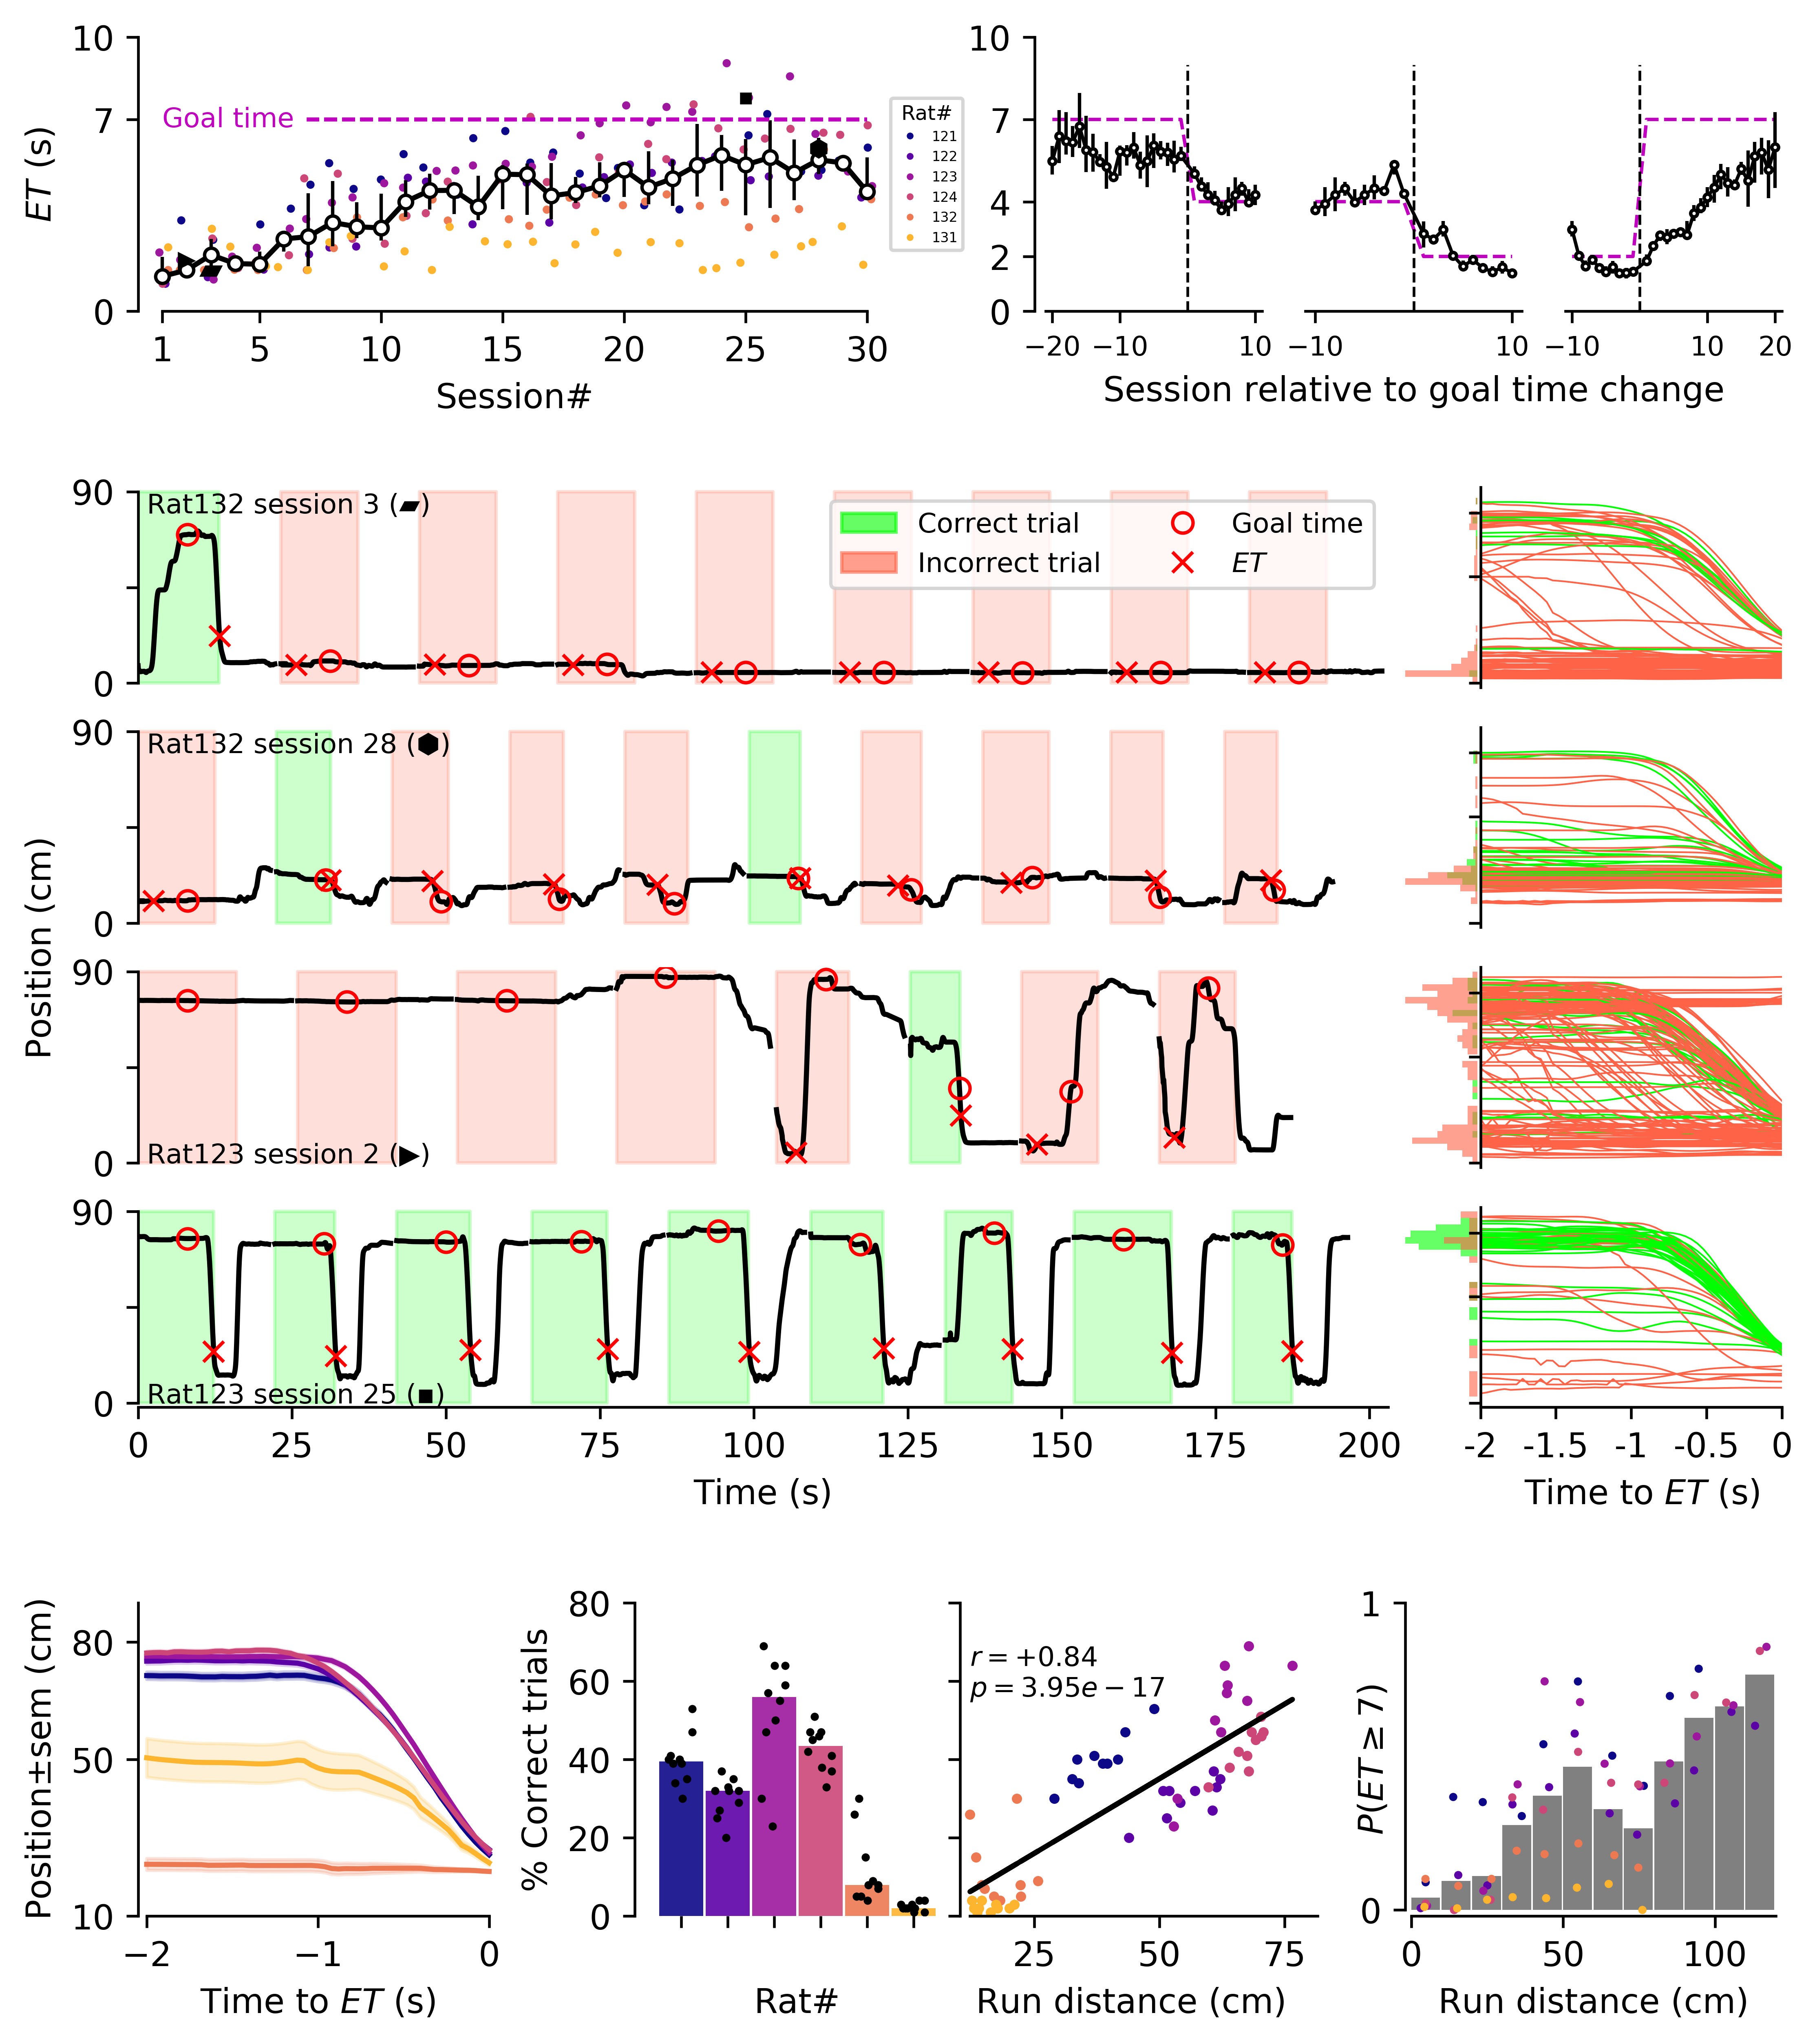

In [102]:
if "__file__" not in dir():
    plt.close('all')
    figsize=(7,8)
    fig=plt.figure(figsize=figsize,dpi=600)
    
    
    ##########################################
    # 1: learning curve
    gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.84, right=0.46, top=.98)
    ax1= fig.add_subplot(gs1[0])
    plot_dotted_learning_curve(ax1, root, animalList1, profile1, TaskParamToPlot1, stop_dayPlot1,colors, legend=True)
    ax1.set_ylabel('$ET$'+' (s)')
    ######highlighting example sessions
    add_markers_to_example_sessions(root, ax1, profile1, stop_dayPlot1, markers1,days)
    
    
    ##########################################
    # 2: goal time change
    gs2= fig.add_gridspec(nrows=1, ncols=1, left=.55, bottom=0.84, right=0.98, top=.98)
    axes2=plot_goal_time_change(root, Profiles2, N2, GT2, badAnimals2, TaskParamToPlot2, wspace2, gs2[0], fig)
    axes2[0].set_ylabel('')
    for ax in axes2:
        ax.tick_params(axis='x', labelsize=8)
    
    
    
    ###########################################
    # 3: Traj aligned on Entrance Time
    gs3= fig.add_gridspec(nrows=4, ncols=1, left=0.76, bottom=0.28, right=0.98, top=0.75)
    
    naiveAx3= fig.add_subplot(gs3[2])
    plot_trajectories_aligned_on_entrance_time(root, naiveAx3, session3goodNaive, Win3)
    
    trainedAx3= fig.add_subplot(gs3[3])
    plot_trajectories_aligned_on_entrance_time(root, trainedAx3, session3goodTrained, Win3)
    
    NaiveStupidAx3= fig.add_subplot(gs3[0])
    plot_trajectories_aligned_on_entrance_time(root, NaiveStupidAx3, session3badNiave, Win3)
    
    trainedStupidAx3= fig.add_subplot(gs3[1])
    plot_trajectories_aligned_on_entrance_time(root, trainedStupidAx3, session3badTrained, Win3)
    
    axes3=[naiveAx3, trainedAx3, NaiveStupidAx3, trainedStupidAx3]
    for ax in axes3:
        ax.set_ylabel('')
        ax.set_yticklabels('')
        ax.xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)
    trainedAx3.xaxis.set_visible(True)
    trainedAx3.spines['bottom'].set_visible(True)
    trainedAx3.set_xlabel('         '+'Time to '+'$ET$'+' (s)')
    
    
    ###########################################
    # 4: consecutive trajectory examples
    gs4= fig.add_gridspec(nrows=4, ncols=1, left=0.02, bottom=0.28, right=0.75, top=0.75)
    
    naiveAx4= fig.add_subplot(gs4[2])
    plot_consecutive_trajectories(root, session3goodNaive, trials4goodNaive, naiveAx4)
    naiveAx4.text(x=0, y=0, s=f' {session3goodNaive[:6]} session {day123_0} ({markers1["naive"]})',fontsize=8)
    
    trainedAx4= fig.add_subplot(gs4[3])
    plot_consecutive_trajectories(root, session3goodTrained, trials4goodTrained, trainedAx4)
    trainedAx4.text(x=0, y=0, s=f' {session3goodTrained[:6]} session {day123_1} ({markers1["trained"]})',fontsize=8)
    
    NaiveStupidAx4= fig.add_subplot(gs4[0])
    plot_consecutive_trajectories(root, session3badNiave, trials4badNiave, NaiveStupidAx4)
    NaiveStupidAx4.text(x=0, y=80, s=f' {session3badNiave[:6]} session {day132_0} ({markers1["stupidNaive"]})',fontsize=8)
    
    trainedStupidAx4= fig.add_subplot(gs4[1])
    plot_consecutive_trajectories(root, session3badTrained, trials4badTrained, trainedStupidAx4)
    trainedStupidAx4.text(x=0, y=80, s=f' {session3badTrained[:6]} session {day132_1} ({markers1["stupidTrained"]})',fontsize=8)
    
    axes4=[naiveAx4, trainedAx4, NaiveStupidAx4, trainedStupidAx4]
    timeMax=max([ax.get_xlim()[1] for ax in axes4])
    for ax in axes4:
        ax.set_xlim([0,timeMax])
        ax.xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_bounds(0,90)
        ax.set_ylabel('')
        ax.set_yticks([0,45,90])
        ax.set_yticklabels([' 0','','90'])
    
    trainedAx4.xaxis.set_visible(True)
    trainedAx4.spines['bottom'].set_visible(True)
    trainedAx4.set_xlabel('Time (s)')
    
    legend4=add_legend_for_consecutive_trajectories(NaiveStupidAx4)
    
    totAx4=fig.add_subplot(gs4[:],frameon=False)
    totAx4.set_ylabel('Position (cm)')
    totAx4.xaxis.set_visible(False)
    totAx4.set_ylim([0,10])
    totAx4.set_yticks([10])
    totAx4.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)
    
    
    
    ###########################################
    # 5: average trajectories
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.02, right=0.23, top=0.18)
    ax5= fig.add_subplot(gs5[0])
    plot_animal_median_trajectory(root,ax5,animalList1,profile1, Win5, cs5, SessionRange5,colors)

    
    ###########################################
    # 6: probabblity of correct
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.76, bottom=0.02, right=0.98, top=0.18)
    ax6= fig.add_subplot(gs6[0])
    plot_cond_prob_correct(ax6, animalList1, profile1, SessionRange5, GT6, distBins6,colors)


    ###########################################
    # 7: percent correct
    gs7= fig.add_gridspec(nrows=1, ncols=1, left=0.31, bottom=0.02, right=0.5, top=0.18)
    ax7= fig.add_subplot(gs7[0])    
    plot_percent_correct(root,ax7,animalList1,profile1, PerfParam7, SessionRange5,colors)
    ax7.set_xticklabels(ax7.get_xticklabels(),color=[0,0,0,0], rotation=0)
    ax7.set_xlabel('Rat#')

    

    ############################################
    # 8: corelation  correct and distance 
    gs8= fig.add_gridspec(nrows=1, ncols=1, left=0.5, bottom=0.02, right=.7, top=0.18)
    ax8= fig.add_subplot(gs8[0])    

    plot_correct_distance_correlation(root, ax8, animalList1, profile1, param8, SessionRange5, colors)
    ax8.set_ylabel('')
    ax8.set_yticklabels('')
    
    
    
#     fig.savefig('/home/david/Pictures/ImmTrd.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')